In [1]:
from traineval.train_eval import TrainerEvaluator

In [2]:
from traineval.utils.convert_arguments import get_environment_arguments

# The arguments you want the agent to use
district_args = ["hour",
                 "month",
                 "carbon_intensity",
                 "electricity_pricing",
                 "outdoor_dry_bulb_temperature_predicted_6h",
                 "outdoor_relative_humidity_predicted_6h"]

building_args = ["non_shiftable_load",
                 "solar_generation",
                 "electrical_storage_soc",
                 "net_electricity_consumption"]

environment_arguments = get_environment_arguments(district_args, building_args)

In [3]:
# Variables
model_type = "ppo"
number_of_epochs = 723
model_seed = 0
save_freq = 20

model_args = [
    [['--env'], str, 'Epoch-Citylearn-v1'],
    [['--hid'], int, 64],
    [['--l'], int, 2],
    [['--gamma'], float, 0.99],
    [['--seed', '-s'], int, model_seed],
    [['--cpu'], int, 4],
    [['--steps'], int, 4000],
    [['--epochs'], int, number_of_epochs],
    [['--exp_name'], str, model_type],
    [['--save_freq'], int, save_freq],
    ]

In [4]:
# Run training (COMMENT OUT mpi_fork IN train.py METHOD run_ppo)
trainer_evaluator = TrainerEvaluator(model_args=model_args, environment_arguments=environment_arguments)
# trainer = trainer_evaluator.setup_trainer(environment_arguments)
# trainer_evaluator.run_trainer(trainer)

In [ ]:
from tqdm import tqdm

eval_freq = save_freq

def get_evaluation_data(num_epochs, eval_freq):

    averaged_scores = []
    times_elapsed = []
    for epoch in tqdm(range(0, num_epochs, eval_freq)):

        # TODO: make this run in parallel
        averaged_score, agent_time = trainer_evaluator.run_evaluation(model_type=model_type, model_seed=model_seed, model_iteration=str(epoch), verbose=False)
        averaged_scores.append(averaged_score)
        times_elapsed.append(agent_time)
        if epoch + eval_freq >= num_epochs and epoch != num_epochs - 1:
            averaged_score, agent_time = trainer_evaluator.run_evaluation(model_type=model_type, model_seed=model_seed, model_iteration=str(epoch), verbose=False)
            averaged_scores.append(averaged_score)
            times_elapsed.append(agent_time)
    return averaged_scores, times_elapsed

averaged_scores, times_elapsed = get_evaluation_data(number_of_epochs, eval_freq)

  0%|          | 0/37 [00:00<?, ?it/s]

In [8]:
print("averages", averaged_scores)
print("times", times_elapsed)

averages [1.8107407250365342, 1.3998746971632354, 1.1935587382172645, 1.0836570804394332, 1.0578642058062495, 1.0404082967965602, 1.0288997094735823, 1.0134363623614253, 1.0023911007494606, 0.9862113132219127, 0.9809697311193055, 0.9772672336646065, 0.9748491355085235, 0.9825068101415179, 0.9811690059447845, 0.9858029012112501, 0.9988590280770269, 0.9800161531221989, 0.993792245560317, 0.9931914547535868, 0.9888257473164401, 0.9862977723702979, 0.9955288314454762, 0.9822016476580395, 0.9647162503166994, 0.9693533125026077, 0.9576412928153649, 0.9604083475297349, 0.9547199177101268, 0.9568380033387444, 0.9575055624203213, 0.9573256871145892, 0.9565366125230067, 0.9589261969103191, 0.9592896506223005, 0.9610015711078835, 0.9547070128224471, 0.9539210968933793]
times [4.921902199999913, 5.257149300000002, 4.9848736999996675, 4.663478599998697, 5.468688800000095, 6.176687599999653, 5.672663200000557, 5.747536099999394, 5.993357100000168, 5.680436899998881, 6.541500799998516, 5.868076899998

In [9]:
import numpy as np
import pandas as pd

df_costs_times = pd.DataFrame({"averages":averaged_scores, "times": np.cumsum(times_elapsed)})

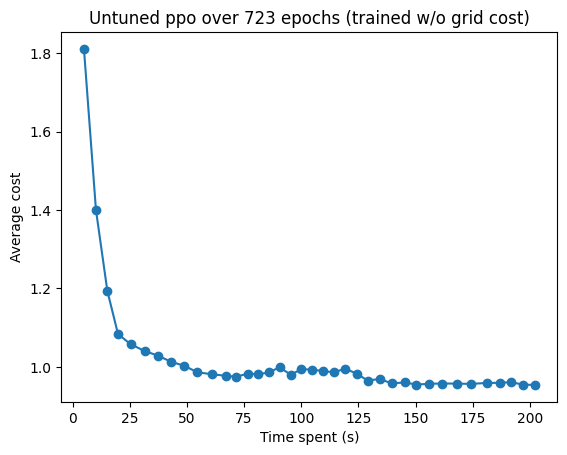

In [10]:
from matplotlib import pyplot as plt

fig,ax=plt.subplots()
ax.plot(df_costs_times.times, df_costs_times.averages, marker="o")
ax.set_xlabel("Time spent (s)")
ax.set_ylabel("Average cost")
ax.set_title(f"Untuned {model_type} over {number_of_epochs} epochs (trained w/o grid cost)")
# ax.plot(gapminder_us.year, gapminder_us["gdpPercap"], marker="o")
plt.show()